In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

# skimage
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
    
    
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(3, 3),):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,orientations=self.orientations,
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block)
            
            return hog_features
        
        hfeatures = np.array([local_hog(x) for x in X])
        return hfeatures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# pipeline model
image = skimage.io.imread('cat.jpg')
# transform image into 80 x 80
image_resize = skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
# rgb to gray
gray = skimage.color.rgb2gray(image_transform)
# hog feature
feature_vector = skimage.feature.hog(gray,
                              orientations=10,
                              pixels_per_cell=(8,8),cells_per_block=(2,2))

In [5]:
feature_vector

array([0.25269896, 0.14211721, 0.03983474, ..., 0.19567423, 0.21307558,
       0.13811837])

In [6]:
import pickle
# load the model
model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler = pickle.load(open('dsa_scaler.pickle','rb'))

In [7]:
feature_vector.shape

(3240,)

In [8]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [9]:
result

array(['cat'], dtype='<U8')

In [10]:
# cal the probabilty 
decision_value = model.decision_function(scalex)

In [11]:
decision_value

array([[-159.61020779,   23.80230912, -100.11661323, -192.58005328,
         -78.30727722, -141.07798841, -198.33429829, -184.09749174,
        -155.4953233 , -132.27490144,  -83.59154785, -206.45538075,
         -80.97982818, -125.55698991, -118.6150512 , -150.75466487,
         -89.49989647, -180.18112585, -100.66977532,  -87.59293734]])

In [12]:
model.classes_

array(['bear', 'cat', 'chicken', 'cow', 'deer', 'dog', 'duck', 'eagle',
       'elephant', 'human', 'lion', 'monkey', 'mouse', 'natural', 'panda',
       'pigeon', 'rabbit', 'sheep', 'tiger', 'wolf'], dtype='<U8')

In [13]:
labels = model.classes_

In [14]:
decision_value = decision_value.flatten()

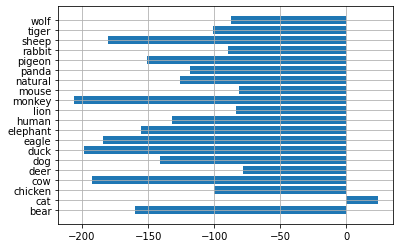

In [15]:
plt.barh(labels,decision_value)
plt.grid()

In [16]:
# cal. z score
z = scipy.stats.zscore(decision_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.01435472, 0.43243159, 0.04332249, 0.00778299, 0.06494866,
       0.02025008, 0.00699436, 0.00911055, 0.01549439, 0.02384566,
       0.0588791 , 0.0060154 , 0.06180454, 0.02701334, 0.03072937,
       0.01691999, 0.05276184, 0.00979769, 0.04287983, 0.05466338])

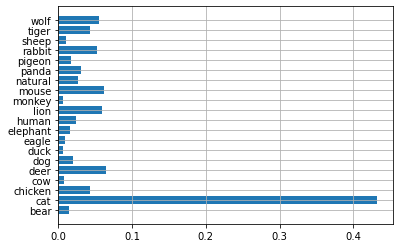

In [17]:
plt.barh(labels,prob_value)
plt.grid()

In [18]:
# top five probabilty values
top_5_prob_ind = prob_value.argsort()[::-1][:5]

In [19]:
top_5_prob_ind

array([ 1,  4, 12, 10, 19], dtype=int64)

In [20]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]

In [21]:
top_prob,top_labels

(array([0.43243159, 0.06494866, 0.06180454, 0.0588791 , 0.05466338]),
 array(['cat', 'deer', 'mouse', 'lion', 'wolf'], dtype='<U8'))

In [22]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,3)})

In [23]:
top_dict

{'cat': 0.432, 'deer': 0.065, 'mouse': 0.062, 'lion': 0.059, 'wolf': 0.055}

In [24]:
def pipeline_model(path,scaler_transform,model_sgd):
    # pipeline model
    image = skimage.io.imread(path)
    # transform image into 80 x 80
    image_resize = skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    # rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    # hog feature
    feature_vector = skimage.feature.hog(gray,
                                  orientations=10,
                                  pixels_per_cell=(8,8),cells_per_block=(2,2))
    # scaling
    
    scalex = scaler_transform.transform(feature_vector.reshape(1,-1))
    result = model_sgd.predict(scalex)
    # decision function # confidence
    decision_value = model_sgd.decision_function(scalex).flatten()
    labels = model_sgd.classes_
    # probability
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    
    # top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    # put in dictornary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
    
    return top_dict

In [27]:
res = pipeline_model('cat.jpg',scaler,model)
res

{'cat': 0.432, 'deer': 0.065, 'mouse': 0.062, 'lion': 0.059, 'wolf': 0.055}

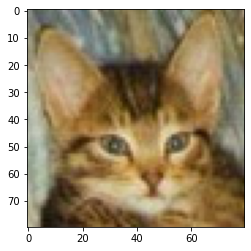

In [28]:
plt.imshow(image)